In [1]:
%env DRJIT_LIBLLVM_PATH /usr/lib/x86_64-linux-gnu/libLLVM-15.0.7.so.1
!echo $DRJIT_LIBLLVM_PATH

env: DRJIT_LIBLLVM_PATH=/usr/lib/x86_64-linux-gnu/libLLVM-15.0.7.so.1
/usr/lib/x86_64-linux-gnu/libLLVM-15.0.7.so.1


In [2]:
%%bash
ln -sf /usr/lib/x86_64-linux-gnu/libstdc++.so.6 ${CONDA_PREFIX}/lib/libstdc++.so.6
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/

In [3]:
import sys
sys.path.insert(0, '/home/jonathan/Documents/mi3-balance/build/python')

import drjit as dr
import mitsuba as mi
from drjit.auto import Float, UInt
import time

# mi.set_variant('cuda_ad_rgb')
mi.set_variant('llvm_ad_rgb')

In [4]:
from furnace_scene import make_scene, visualize_scene

# two cases to try:
# scene is uniform, BSDF param is a texture
# scene is textured, BSDF param is a texture
scene = make_scene(use_texture=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..4.83991].


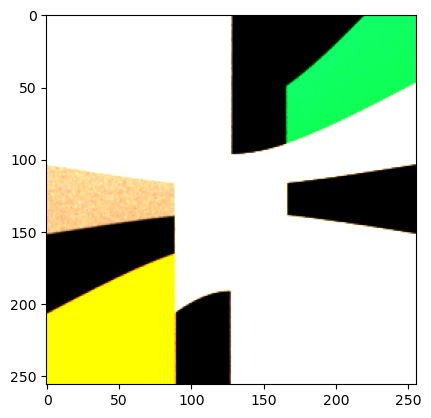

In [5]:
image = mi.render(scene)

import matplotlib.pyplot as plt
plt.imshow(image)

In [6]:
def define_BSDF_textured():
    # n_px = 8
    # albedo_tex = mi.Bitmap(dr.full(mi.TensorXf, 0.5, shape=(n_px, n_px, 3)))
    albedo_tex = mi.Bitmap(dr.full(mi.TensorXf, 0.5, shape=(9, 10, 3)))
    # albedo_tex = mi.Bitmap("/home/jonathan/Documents/mi3-balance/resources/data/common/textures/leaf_mask.png")
    # albedo_tex = mi.Bitmap("/home/jonathan/Documents/mi3-balance/resources/data/common/textures/carrot.png")
    bsdf = mi.load_dict({
        "type": "diffuse",
        "reflectance": {
            "type": "bitmap",
            "id": "albedo_tex",
            "bitmap": albedo_tex,
            "raw": True
        }
    })
    param_key = "reflectance.data"
    return bsdf, param_key

In [7]:
from radiosity import SceneSurfaceSampler, RadianceCacheMITSUBA, compute_loss

NUM_WI_DIRECTIONS = 256 # 32
SAMPLES_PER_RAY_LI = 32 # 32
SAMPLES_PER_RAY_LO = 64 # 128
NUM_GEO_SAMPLES = 128 # 128

scene_sampler = SceneSurfaceSampler(scene)
radiance_cache = RadianceCacheMITSUBA(scene, 
                                      spp_per_wo=SAMPLES_PER_RAY_LO, 
                                      spp_per_wi=SAMPLES_PER_RAY_LI)


In [8]:
# bsdf_train, key = define_BSDF_textured()
# x_init = mi.traverse(bsdf_train)[key].numpy()
# x_ref = mi.traverse(scene)['mysphere.bsdf.reflectance.data'].numpy()

# import numpy as np

# print(np.allclose(x_init,x_ref))

# NUM_WI_DIRECTIONS = 2 # 32
# SAMPLES_PER_RAY_LI = 64 # 32
# SAMPLES_PER_RAY_LO = 64 # 128
# NUM_GEO_SAMPLES = 6 # 128

# scene_sampler = SceneSurfaceSampler(scene)
# radiance_cache = RadianceCacheMITSUBA(scene, SAMPLES_PER_RAY_LO, SAMPLES_PER_RAY_LI)

# compute_loss(scene_sampler, radiance_cache, bsdf_train, 
#         NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS)

In [9]:
# Initialize BSDF to train
bsdf_train, key = define_BSDF_textured()
params = mi.traverse(bsdf_train)
opt = mi.ad.Adam(lr=0.05)
dr.enable_grad(params[key])
opt[key] = params[key]
params.update(opt)

x0 = params[key].numpy()
# plt.imshow(opt[key])

losses = []
for it in range(100):
    time1 = time.time()

    # Evaluate the objective function for the current BSDF params
    loss = compute_loss(scene_sampler, radiance_cache, bsdf_train, 
        NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS)

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    # Post-process the optimized parameters to ensure legal color values.
    opt[key] = dr.clip(opt[key], 0.0, 1.0)

    # Update the scene state to the new optimized values
    params.update(opt)

    losses.append(loss.numpy())
    time2 = time.time()
    # print(f"Iteration {1+it:03d} [{time2 - time1:2f}]: Loss = {loss}, p = {opt[key]}")
    print(f"Iteration {1+it:03d} [{time2 - time1:2f}]: Loss = {loss}")

Iteration 001 [0.113723]: Loss = [1.92993]
Iteration 002 [0.089869]: Loss = [1.60469]
Iteration 003 [0.104683]: Loss = [1.32293]
Iteration 004 [0.097478]: Loss = [1.08342]
Iteration 005 [0.107929]: Loss = [0.883965]
Iteration 006 [0.105776]: Loss = [0.72206]
Iteration 007 [0.109641]: Loss = [0.594814]
Iteration 008 [0.105923]: Loss = [0.498797]
Iteration 009 [0.100342]: Loss = [0.429871]
Iteration 010 [0.094320]: Loss = [0.383203]
Iteration 011 [0.093669]: Loss = [0.353695]
Iteration 012 [0.102940]: Loss = [0.35158]
Iteration 013 [0.110158]: Loss = [0.35992]
Iteration 014 [0.106125]: Loss = [0.362881]
Iteration 015 [0.099697]: Loss = [0.360977]
Iteration 016 [0.097419]: Loss = [0.35665]
Iteration 017 [0.096234]: Loss = [0.350929]
Iteration 018 [0.106122]: Loss = [0.344179]
Iteration 019 [0.094229]: Loss = [0.336563]
Iteration 020 [0.105875]: Loss = [0.328868]
Iteration 021 [0.104190]: Loss = [0.321715]
Iteration 022 [0.096206]: Loss = [0.315478]
Iteration 023 [0.111868]: Loss = [0.3104

Text(0, 0.5, 'Loss')

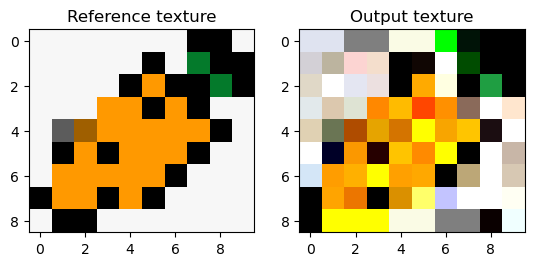

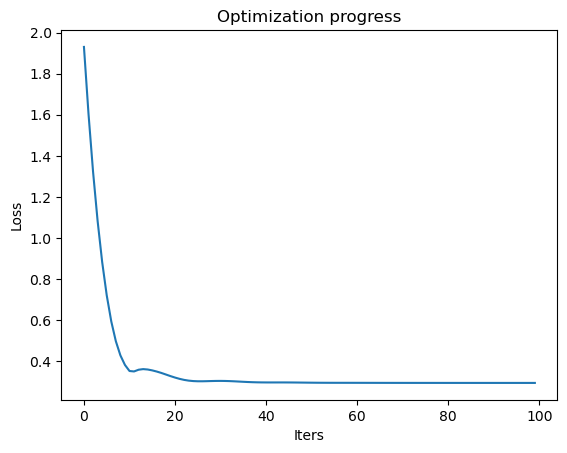

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.subplot(121)
plt.title("Reference texture")
texture_ref = mi.traverse(scene)['mysphere.bsdf.reflectance.data']
plt.imshow(texture_ref)
plt.subplot(122)
plt.title("Optimized texture")
texture_out = mi.TensorXf(params[key])
plt.imshow(texture_out)

plt.figure()
plt.title("Optimization progress")
plt.plot(np.array(losses))
plt.xlabel("Iters")
plt.ylabel("Loss")